<a href="https://colab.research.google.com/github/InvestitoreComune/analysis/blob/main/bond_ladder_vs_etf_obbligazionario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy pandas matplotlib seaborn scipy yfinance openpyxl


################################################################################
#  BOND LADDER vs ETF OBBLIGAZIONARIO: ANALISI COMPARATIVA
#  Capitale: €50,000.00 | Periodo: 2015-01-01 - 2025-11-01
################################################################################

1. Generazione curve rendimenti BTP storiche...

2. Simulazione BOND LADDER...

COSTRUZIONE BOND LADDER INIZIALE
Capitale totale: €50,000.00
Numero pioli: 5
Capitale per piolo: €10,000.00

Piolo 1 - Scadenza 1 anni:
  YTM: 1.50%
  Capitale nominale: €9,987.05
  Cedola annua lorda: €149.81
  Costi acquisto: €12.95

Piolo 2 - Scadenza 2 anni:
  YTM: 1.70%
  Capitale nominale: €9,987.05
  Cedola annua lorda: €169.78
  Costi acquisto: €12.95

Piolo 3 - Scadenza 3 anni:
  YTM: 1.80%
  Capitale nominale: €9,987.05
  Cedola annua lorda: €179.77
  Costi acquisto: €12.95

Piolo 4 - Scadenza 4 anni:
  YTM: 1.90%
  Capitale nominale: €9,987.05
  Cedola annua lorda: €189.75
  Costi acquisto: €12.95

Piolo 5 - Scadenza 5 

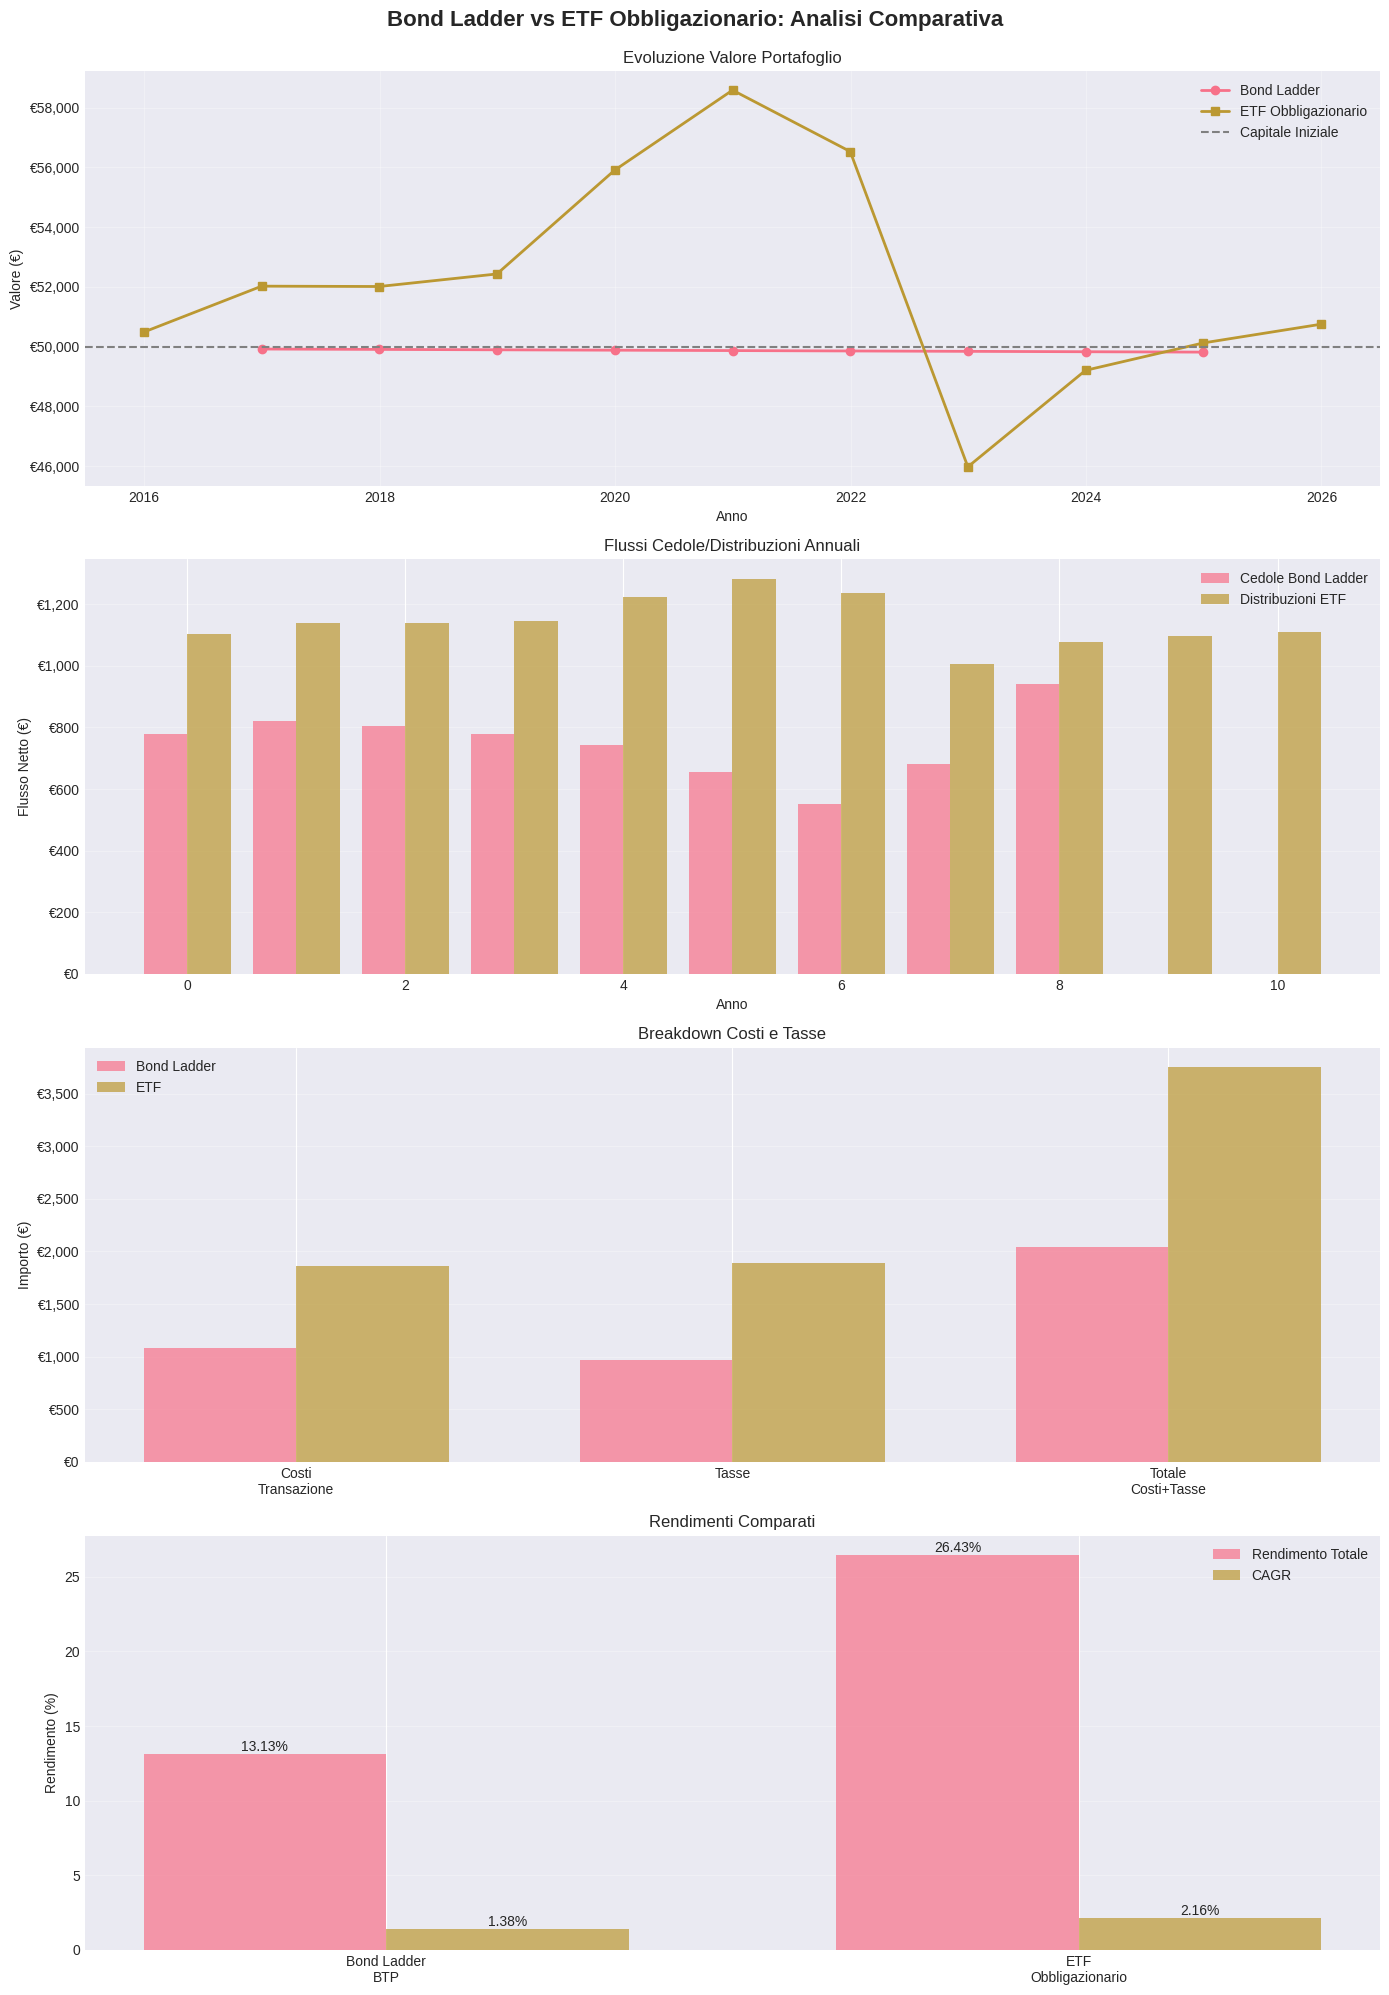


ANALISI DI SENSIBILITÀ

     Scenario  Valore Finale  Rendimento %
    Tassi -1%   53519.236853      7.038474
Tassi Attuali   58356.605141     16.713210
    Tassi +1%   63583.982820     27.167966
    Tassi +2%   69229.074153     38.458148


6. Esportazione risultati...
✓ Risultati esportati in 'bond_ladder_vs_etf_risultati.xlsx'


ANALISI COMPLETATA CON SUCCESSO!



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# =============================================================================
# PARAMETRI CONFIGURABILI
# =============================================================================

# Capitale iniziale
CAPITALE_INIZIALE = 50000  # Euro

# Periodo di analisi
DATA_INIZIO = '2015-01-01'
DATA_FINE = '2025-11-01'

# Parametri fiscali Italia
TASSAZIONE_BTP = 0.125  # 12.5% su BTP
TASSAZIONE_ETF_GOV = 0.125  # 12.5% sulla parte titoli di Stato
TASSAZIONE_ETF_CORPORATE = 0.26  # 26% sulla parte corporate
IMPOSTA_BOLLO = 0.002  # 0.2% annuo

# Costi transazione
COMMISSIONE_BROKER_BTP = 2.95  # Euro per transazione
SPREAD_BTP = 0.001  # 0.1% bid-ask spread medio
TER_ETF = 0.0012  # 0.12% annuo (es. Xtrackers EUR Govt Bond)

# Composizione ETF (esempio realistico)
PERCENTUALE_GOV_ETF = 1.0  # 100% governativi per questo confronto

# Bond Ladder: numero di pioli
NUM_PIOLI = 5  # Scala 5 anni

# =============================================================================
# CLASSE BOND LADDER
# =============================================================================

class BondLadder:
    """
    Simula una strategia bond ladder con BTP italiani
    """

    def __init__(self, capitale, num_pioli, start_date):
        self.capitale_iniziale = capitale
        self.num_pioli = num_pioli
        self.capitale_per_piolo = capitale / num_pioli
        self.start_date = pd.to_datetime(start_date)
        self.portafoglio = []
        self.storia_valore = []
        self.cedole_ricevute = []
        self.costi_totali = 0

    def costruisci_ladder_iniziale(self, rendimenti_btp):
        """
        Costruisce la ladder iniziale acquistando BTP con scadenze 1-5 anni
        """
        print(f"\n{'='*60}")
        print(f"COSTRUZIONE BOND LADDER INIZIALE")
        print(f"{'='*60}")
        print(f"Capitale totale: €{self.capitale_iniziale:,.2f}")
        print(f"Numero pioli: {self.num_pioli}")
        print(f"Capitale per piolo: €{self.capitale_per_piolo:,.2f}\n")

        for i in range(1, self.num_pioli + 1):
            ytm = rendimenti_btp.get(i, 2.5) / 100

            # Calcolo costi acquisto
            costo_transazione = COMMISSIONE_BROKER_BTP
            costo_spread = self.capitale_per_piolo * SPREAD_BTP
            costi_totali_acquisto = costo_transazione + costo_spread

            # Capitale netto investito
            capitale_netto = self.capitale_per_piolo - costi_totali_acquisto

            bond = {
                'scadenza_anni': i,
                'data_acquisto': self.start_date,
                'data_scadenza': self.start_date + pd.DateOffset(years=i),
                'capitale_nominale': capitale_netto,
                'ytm': ytm,
                'cedola_annua': capitale_netto * ytm,
                'costi_acquisto': costi_totali_acquisto,
                'prezzo_acquisto': 100
            }

            self.portafoglio.append(bond)
            self.costi_totali += costi_totali_acquisto

            print(f"Piolo {i} - Scadenza {i} anni:")
            print(f"  YTM: {ytm*100:.2f}%")
            print(f"  Capitale nominale: €{capitale_netto:,.2f}")
            print(f"  Cedola annua lorda: €{bond['cedola_annua']:,.2f}")
            print(f"  Costi acquisto: €{costi_totali_acquisto:.2f}\n")

    def simula_periodo(self, data_corrente, rendimenti_btp_correnti):
        """
        Simula un periodo (tipicamente 1 anno) della strategia
        """
        # Incassa cedole
        cedole_annuali = sum(bond['cedola_annua'] for bond in self.portafoglio)
        tasse_cedole = cedole_annuali * TASSAZIONE_BTP
        cedole_nette = cedole_annuali - tasse_cedole

        self.cedole_ricevute.append({
            'data': data_corrente,
            'cedole_lorde': cedole_annuali,
            'tasse': tasse_cedole,
            'cedole_nette': cedole_nette
        })

        # Identifica BTP in scadenza
        btp_scaduti = [b for b in self.portafoglio
                       if b['data_scadenza'] <= data_corrente]

        capitale_da_reinvestire = 0

        if btp_scaduti:
            for bond_scaduto in btp_scaduti:
                capitale_da_reinvestire += bond_scaduto['capitale_nominale']
                self.portafoglio.remove(bond_scaduto)

            # Reinvesti in nuovo BTP a 5 anni
            ytm_nuovo = rendimenti_btp_correnti.get(5, 3.0) / 100

            costo_transazione = COMMISSIONE_BROKER_BTP
            costo_spread = capitale_da_reinvestire * SPREAD_BTP
            costi_reinvestimento = costo_transazione + costo_spread

            capitale_netto_reinvestito = capitale_da_reinvestire - costi_reinvestimento

            nuovo_bond = {
                'scadenza_anni': 5,
                'data_acquisto': data_corrente,
                'data_scadenza': data_corrente + pd.DateOffset(years=5),
                'capitale_nominale': capitale_netto_reinvestito,
                'ytm': ytm_nuovo,
                'cedola_annua': capitale_netto_reinvestito * ytm_nuovo,
                'costi_acquisto': costi_reinvestimento,
                'prezzo_acquisto': 100
            }

            self.portafoglio.append(nuovo_bond)
            self.costi_totali += costi_reinvestimento

        # Calcola valore corrente del portafoglio
        valore_corrente = sum(b['capitale_nominale'] for b in self.portafoglio)

        # Applica imposta bollo
        imposta_bollo_annua = valore_corrente * IMPOSTA_BOLLO
        self.costi_totali += imposta_bollo_annua

        self.storia_valore.append({
            'data': data_corrente,
            'valore_portafoglio': valore_corrente,
            'cedole_nette_annuali': cedole_nette,
            'imposta_bollo': imposta_bollo_annua,
            'num_bond': len(self.portafoglio)
        })

        return valore_corrente + cedole_nette

    def calcola_performance(self):
        """
        Calcola metriche di performance complessive
        """
        df_storia = pd.DataFrame(self.storia_valore)
        df_cedole = pd.DataFrame(self.cedole_ricevute)

        valore_finale = df_storia['valore_portafoglio'].iloc[-1]
        cedole_totali_nette = df_cedole['cedole_nette'].sum()

        valore_totale_finale = valore_finale + cedole_totali_nette

        rendimento_totale = ((valore_totale_finale - self.capitale_iniziale) /
                            self.capitale_iniziale * 100)

        anni = len(df_storia)
        cagr = (((valore_totale_finale / self.capitale_iniziale) ** (1/anni)) - 1) * 100

        return {
            'valore_finale': valore_finale,
            'cedole_totali_nette': cedole_totali_nette,
            'valore_totale_finale': valore_totale_finale,
            'rendimento_totale_pct': rendimento_totale,
            'cagr': cagr,
            'costi_totali': self.costi_totali,
            'tasse_totali': df_cedole['tasse'].sum(),
            'df_storia': df_storia,
            'df_cedole': df_cedole
        }

# =============================================================================
# CLASSE ETF OBBLIGAZIONARIO
# =============================================================================

class ETFObbligazionario:
    """
    Simula investimento in ETF obbligazionario governativo europeo
    """

    def __init__(self, capitale, ticker, start_date):
        self.capitale_iniziale = capitale
        self.ticker = ticker
        self.start_date = pd.to_datetime(start_date)
        self.num_quote = 0
        self.storia_valore = []
        self.distribuzioni = []
        self.costi_totali = 0

    def scarica_dati_storici(self, end_date):
        """
        Scarica dati storici ETF da Yahoo Finance
        """
        try:
            print(f"\nScaricamento dati {self.ticker}...")
            dati_raw = yf.download(self.ticker,
                                   start=self.start_date,
                                   end=end_date,
                                   progress=False)

            if dati_raw.empty:
                print(f"ATTENZIONE: Nessun dato trovato per {self.ticker}")
                print("Generazione dati sintetici...")
                self.genera_dati_sintetici(end_date)
            else:
                # CORREZIONE: Appiattisci il MultiIndex se presente
                if isinstance(dati_raw.columns, pd.MultiIndex):
                    dati_raw.columns = dati_raw.columns.get_level_values(0)

                self.dati_etf = dati_raw
                print(f"Dati scaricati: {len(self.dati_etf)} giorni")

        except Exception as e:
            print(f"Errore download: {e}")
            print("Generazione dati sintetici...")
            self.genera_dati_sintetici(end_date)

    def genera_dati_sintetici(self, end_date):
        """
        Genera dati sintetici per l'ETF basati su parametri realistici
        """
        date_range = pd.date_range(start=self.start_date, end=end_date, freq='D')

        # Parametri realistici per ETF gov bond EUR
        rendimento_annuo_medio = 0.025  # 2.5%
        volatilita_annua = 0.04  # 4%

        giorni = len(date_range)
        rendimenti_giornalieri = np.random.normal(
            rendimento_annuo_medio / 252,
            volatilita_annua / np.sqrt(252),
            giorni
        )

        # Prezzo iniziale
        prezzo_iniziale = 50.0
        prezzi = prezzo_iniziale * np.exp(np.cumsum(rendimenti_giornalieri))

        self.dati_etf = pd.DataFrame({
            'Close': prezzi
        }, index=date_range)

        print(f"Dati sintetici generati: {len(self.dati_etf)} giorni")

    def acquista_iniziale(self):
        """
        Acquisto iniziale ETF
        """
        # CORREZIONE: Estrai il valore scalare correttamente
        prezzo_iniziale = float(self.dati_etf['Close'].iloc[0])

        # Costi acquisto (spread bid-ask tipico ETF)
        costo_spread = self.capitale_iniziale * 0.0005  # 0.05%

        capitale_netto = self.capitale_iniziale - costo_spread
        self.num_quote = capitale_netto / prezzo_iniziale
        self.costi_totali += costo_spread

        print(f"\n{'='*60}")
        print(f"ACQUISTO ETF INIZIALE")
        print(f"{'='*60}")
        print(f"Ticker: {self.ticker}")
        print(f"Capitale investito: €{self.capitale_iniziale:,.2f}")
        print(f"Prezzo quota: €{prezzo_iniziale:.2f}")
        print(f"Numero quote: {self.num_quote:.4f}")
        print(f"Costo spread: €{costo_spread:.2f}\n")

    def simula_periodo_completo(self):
        """
        Simula l'intero periodo di detenzione ETF
        """
        # Resample a frequenza annuale per confronto con bond ladder
        dati_annuali = self.dati_etf.resample('Y').last()

        for data in dati_annuali.index:
            # CORREZIONE: Estrai il valore scalare correttamente
            prezzo_corrente = float(dati_annuali.loc[data, 'Close'])
            valore_portafoglio = self.num_quote * prezzo_corrente

            # Simula distribuzione annuale (dividend yield tipico 2-3%)
            dividend_yield = 0.025
            distribuzione_lorda = valore_portafoglio * dividend_yield

            # Tassazione distribuzione
            tasse_distribuzione = distribuzione_lorda * (
                PERCENTUALE_GOV_ETF * TASSAZIONE_ETF_GOV +
                (1 - PERCENTUALE_GOV_ETF) * TASSAZIONE_ETF_CORPORATE
            )

            distribuzione_netta = distribuzione_lorda - tasse_distribuzione

            # TER annuale
            ter_annuale = valore_portafoglio * TER_ETF

            # Imposta bollo
            imposta_bollo_annua = valore_portafoglio * IMPOSTA_BOLLO

            self.costi_totali += ter_annuale + imposta_bollo_annua

            self.storia_valore.append({
                'data': data,
                'prezzo_quota': prezzo_corrente,
                'valore_portafoglio': valore_portafoglio,
                'distribuzione_netta': distribuzione_netta,
                'ter': ter_annuale,
                'imposta_bollo': imposta_bollo_annua
            })

            self.distribuzioni.append({
                'data': data,
                'distribuzione_lorda': distribuzione_lorda,
                'tasse': tasse_distribuzione,
                'distribuzione_netta': distribuzione_netta
            })

    def calcola_performance(self):
        """
        Calcola metriche performance ETF
        """
        df_storia = pd.DataFrame(self.storia_valore)
        df_distribuzioni = pd.DataFrame(self.distribuzioni)

        valore_finale = df_storia['valore_portafoglio'].iloc[-1]
        distribuzioni_totali_nette = df_distribuzioni['distribuzione_netta'].sum()

        valore_totale_finale = valore_finale + distribuzioni_totali_nette

        # Calcola plusvalenza
        plusvalenza_lorda = valore_finale - self.capitale_iniziale
        tasse_plusvalenza = max(0, plusvalenza_lorda * (
            PERCENTUALE_GOV_ETF * TASSAZIONE_ETF_GOV +
            (1 - PERCENTUALE_GOV_ETF) * TASSAZIONE_ETF_CORPORATE
        ))

        valore_finale_netto = valore_finale - tasse_plusvalenza
        valore_totale_finale_netto = valore_finale_netto + distribuzioni_totali_nette

        rendimento_totale = ((valore_totale_finale_netto - self.capitale_iniziale) /
                            self.capitale_iniziale * 100)

        anni = len(df_storia)
        cagr = (((valore_totale_finale_netto / self.capitale_iniziale) ** (1/anni)) - 1) * 100

        return {
            'valore_finale': valore_finale_netto,
            'distribuzioni_totali_nette': distribuzioni_totali_nette,
            'valore_totale_finale': valore_totale_finale_netto,
            'rendimento_totale_pct': rendimento_totale,
            'cagr': cagr,
            'costi_totali': self.costi_totali,
            'tasse_totali': df_distribuzioni['tasse'].sum() + tasse_plusvalenza,
            'df_storia': df_storia,
            'df_distribuzioni': df_distribuzioni
        }

# =============================================================================
# FUNZIONI UTILITY
# =============================================================================

def genera_curva_rendimenti_storica(data_inizio, data_fine):
    """
    Genera curve di rendimento BTP storiche simulate
    """
    date_range = pd.date_range(start=data_inizio, end=data_fine, freq='Y')

    curve_rendimenti = {}

    for data in date_range:
        anno = data.year

        # Simula evoluzione storica tassi
        if anno <= 2016:
            base = 1.5
        elif anno <= 2019:
            base = 1.0
        elif anno == 2020:
            base = 0.5
        elif anno == 2021:
            base = 0.3
        elif anno == 2022:
            base = 2.5
        elif anno == 2023:
            base = 4.0
        elif anno == 2024:
            base = 3.5
        else:
            base = 3.0

        curve_rendimenti[data] = {
            1: base + 0.0,
            2: base + 0.2,
            3: base + 0.3,
            4: base + 0.4,
            5: base + 0.5
        }

    return curve_rendimenti

def confronta_strategie(perf_ladder, perf_etf):
    """
    Confronta le performance delle due strategie
    """
    print(f"\n{'='*80}")
    print(f"CONFRONTO PERFORMANCE FINALE")
    print(f"{'='*80}\n")

    confronto = pd.DataFrame({
        'Bond Ladder BTP': [
            f"€{CAPITALE_INIZIALE:,.2f}",
            f"€{perf_ladder['valore_totale_finale']:,.2f}",
            f"€{perf_ladder['valore_totale_finale'] - CAPITALE_INIZIALE:,.2f}",
            f"{perf_ladder['rendimento_totale_pct']:.2f}%",
            f"{perf_ladder['cagr']:.2f}%",
            f"€{perf_ladder['cedole_totali_nette']:,.2f}",
            f"€{perf_ladder['costi_totali']:,.2f}",
            f"€{perf_ladder['tasse_totali']:,.2f}",
            f"€{perf_ladder['costi_totali'] + perf_ladder['tasse_totali']:,.2f}"
        ],
        'ETF Obbligazionario': [
            f"€{CAPITALE_INIZIALE:,.2f}",
            f"€{perf_etf['valore_totale_finale']:,.2f}",
            f"€{perf_etf['valore_totale_finale'] - CAPITALE_INIZIALE:,.2f}",
            f"{perf_etf['rendimento_totale_pct']:.2f}%",
            f"{perf_etf['cagr']:.2f}%",
            f"€{perf_etf['distribuzioni_totali_nette']:,.2f}",
            f"€{perf_etf['costi_totali']:,.2f}",
            f"€{perf_etf['tasse_totali']:,.2f}",
            f"€{perf_etf['costi_totali'] + perf_etf['tasse_totali']:,.2f}"
        ]
    }, index=[
        'Capitale Iniziale',
        'Valore Finale (netto)',
        'Guadagno Totale',
        'Rendimento Totale %',
        'CAGR %',
        'Flussi Cedole/Distribuzioni',
        'Costi Totali',
        'Tasse Totali',
        'Costi + Tasse Totali'
    ])

    print(confronto.to_string())

    diff_valore = perf_ladder['valore_totale_finale'] - perf_etf['valore_totale_finale']
    diff_pct = (diff_valore / CAPITALE_INIZIALE) * 100

    print(f"\n{'='*80}")
    if diff_valore > 0:
        print(f"✓ Bond Ladder ha generato €{abs(diff_valore):,.2f} in più ({diff_pct:+.2f}%)")
    else:
        print(f"✓ ETF ha generato €{abs(diff_valore):,.2f} in più ({abs(diff_pct):.2f}%)")
    print(f"{'='*80}\n")

    return confronto

def visualizza_confronto(perf_ladder, perf_etf):
    """
    Crea visualizzazioni comparative
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 20))
    fig.suptitle('Bond Ladder vs ETF Obbligazionario: Analisi Comparativa',
                 fontsize=16, fontweight='bold', y=0.995)

    # 1. Evoluzione valore portafoglio
    ax1 = axes[0]
    df_ladder = perf_ladder['df_storia']
    df_etf = perf_etf['df_storia']

    ax1.plot(df_ladder['data'], df_ladder['valore_portafoglio'],
             label='Bond Ladder', linewidth=2, marker='o')
    ax1.plot(df_etf['data'], df_etf['valore_portafoglio'],
             label='ETF Obbligazionario', linewidth=2, marker='s')
    ax1.axhline(y=CAPITALE_INIZIALE, color='gray', linestyle='--',
                label='Capitale Iniziale')
    ax1.set_xlabel('Anno')
    ax1.set_ylabel('Valore (€)')
    ax1.set_title('Evoluzione Valore Portafoglio')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

    # 2. Flussi cedole/distribuzioni annuali
    ax2 = axes[1]
    df_cedole_ladder = perf_ladder['df_cedole']
    df_distr_etf = perf_etf['df_distribuzioni']

    x_ladder = range(len(df_cedole_ladder))
    x_etf = range(len(df_distr_etf))

    ax2.bar([x - 0.2 for x in x_ladder], df_cedole_ladder['cedole_nette'],
            width=0.4, label='Cedole Bond Ladder', alpha=0.7)
    ax2.bar([x + 0.2 for x in x_etf], df_distr_etf['distribuzione_netta'],
            width=0.4, label='Distribuzioni ETF', alpha=0.7)
    ax2.set_xlabel('Anno')
    ax2.set_ylabel('Flusso Netto (€)')
    ax2.set_title('Flussi Cedole/Distribuzioni Annuali')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

    # 3. Breakdown costi e tasse
    ax3 = axes[2]
    categorie = ['Costi\nTransazione', 'Tasse', 'Totale\nCosti+Tasse']

    ladder_valori = [
        perf_ladder['costi_totali'],
        perf_ladder['tasse_totali'],
        perf_ladder['costi_totali'] + perf_ladder['tasse_totali']
    ]

    etf_valori = [
        perf_etf['costi_totali'],
        perf_etf['tasse_totali'],
        perf_etf['costi_totali'] + perf_etf['tasse_totali']
    ]

    x = np.arange(len(categorie))
    width = 0.35

    ax3.bar(x - width/2, ladder_valori, width, label='Bond Ladder', alpha=0.7)
    ax3.bar(x + width/2, etf_valori, width, label='ETF', alpha=0.7)
    ax3.set_ylabel('Importo (€)')
    ax3.set_title('Breakdown Costi e Tasse')
    ax3.set_xticks(x)
    ax3.set_xticklabels(categorie)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

    # 4. Rendimento totale comparato
    ax4 = axes[3]
    strategie = ['Bond Ladder\nBTP', 'ETF\nObbligazionario']
    rendimenti = [perf_ladder['rendimento_totale_pct'],
                  perf_etf['rendimento_totale_pct']]
    cagr = [perf_ladder['cagr'], perf_etf['cagr']]

    x = np.arange(len(strategie))
    width = 0.35

    bars1 = ax4.bar(x - width/2, rendimenti, width, label='Rendimento Totale', alpha=0.7)
    bars2 = ax4.bar(x + width/2, cagr, width, label='CAGR', alpha=0.7)

    # Aggiungi valori sulle barre
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%', ha='center', va='bottom')

    ax4.set_ylabel('Rendimento (%)')
    ax4.set_title('Rendimenti Comparati')
    ax4.set_xticks(x)
    ax4.set_xticklabels(strategie)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.savefig('bond_ladder_vs_etf_analisi.png', dpi=300, bbox_inches='tight')
    print("\n✓ Grafici salvati in 'bond_ladder_vs_etf_analisi.png'")
    plt.show()

def analisi_sensibilita(capitale, rendimenti_base):
    """
    Analisi di sensibilità su variazione tassi
    """
    print(f"\n{'='*80}")
    print(f"ANALISI DI SENSIBILITÀ")
    print(f"{'='*80}\n")

    scenari = {
        'Tassi -1%': -1.0,
        'Tassi Attuali': 0.0,
        'Tassi +1%': 1.0,
        'Tassi +2%': 2.0
    }

    risultati = []

    for nome_scenario, variazione in scenari.items():
        rendimenti_scenario = {k: v + variazione
                              for k, v in rendimenti_base.items()}

        ytm_medio = np.mean(list(rendimenti_scenario.values())) / 100
        rendimento_annuo = ytm_medio * (1 - TASSAZIONE_BTP)
        valore_finale = capitale * ((1 + rendimento_annuo) ** 10)

        risultati.append({
            'Scenario': nome_scenario,
            'Valore Finale': valore_finale,
            'Rendimento %': ((valore_finale - capitale) / capitale * 100)
        })

    df_sensibilita = pd.DataFrame(risultati)
    print(df_sensibilita.to_string(index=False))
    print()

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """
    Funzione principale per eseguire l'analisi completa
    """
    print(f"\n{'#'*80}")
    print(f"#  BOND LADDER vs ETF OBBLIGAZIONARIO: ANALISI COMPARATIVA")
    print(f"#  Capitale: €{CAPITALE_INIZIALE:,.2f} | Periodo: {DATA_INIZIO} - {DATA_FINE}")
    print(f"{'#'*80}\n")

    # 1. Genera curve rendimenti storiche
    print("1. Generazione curve rendimenti BTP storiche...")
    curve_rendimenti = genera_curva_rendimenti_storica(DATA_INIZIO, DATA_FINE)
    rendimenti_iniziali = list(curve_rendimenti.values())[0]

    # 2. Simula Bond Ladder
    print("\n2. Simulazione BOND LADDER...")
    ladder = BondLadder(CAPITALE_INIZIALE, NUM_PIOLI, DATA_INIZIO)
    ladder.costruisci_ladder_iniziale(rendimenti_iniziali)

    for data, rendimenti in list(curve_rendimenti.items())[1:]:
        ladder.simula_periodo(data, rendimenti)

    perf_ladder = ladder.calcola_performance()

    # 3. Simula ETF Obbligazionario
    print("\n3. Simulazione ETF OBBLIGAZIONARIO...")
    etf = ETFObbligazionario(CAPITALE_INIZIALE, "XGLE.MI", DATA_INIZIO)
    etf.scarica_dati_storici(DATA_FINE)
    etf.acquista_iniziale()
    etf.simula_periodo_completo()

    perf_etf = etf.calcola_performance()

    # 4. Confronto risultati
    print("\n4. Confronto strategie...")
    confronto_df = confronta_strategie(perf_ladder, perf_etf)

    # 5. Visualizzazioni
    print("\n5. Generazione visualizzazioni...")
    visualizza_confronto(perf_ladder, perf_etf)

    # 6. Analisi sensibilità
    analisi_sensibilita(CAPITALE_INIZIALE, rendimenti_iniziali)

    # 7. Esporta risultati
    print("\n6. Esportazione risultati...")
    with pd.ExcelWriter('bond_ladder_vs_etf_risultati.xlsx', engine='openpyxl') as writer:
        confronto_df.to_excel(writer, sheet_name='Confronto')
        perf_ladder['df_storia'].to_excel(writer, sheet_name='Bond Ladder Storia')
        perf_etf['df_storia'].to_excel(writer, sheet_name='ETF Storia')

    print("✓ Risultati esportati in 'bond_ladder_vs_etf_risultati.xlsx'\n")

    print(f"\n{'='*80}")
    print("ANALISI COMPLETATA CON SUCCESSO!")
    print(f"{'='*80}\n")

    return perf_ladder, perf_etf, confronto_df

if __name__ == "__main__":
    perf_ladder, perf_etf, confronto = main()